### **Preparation**
Install and import the libraries and modules needed for this guide.

In [ ]:
!pip install torch==2.2.1 bitsandbytes transformers datasets peft easydict --quiet

In [ ]:
import os, re, json, random, time, huggingface_hub, transformers, torch, gc
from datetime import datetime

from typing import Any, Dict, List, Tuple, Union
import numpy as np, pandas as pd

from easydict import EasyDict # Substitute for the argparse library for Colab settings
from accelerate import Accelerator
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, BatchEncoding, LlamaTokenizer, DataCollatorForSeq2Seq

from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model, PeftModel
from google.colab import drive
drive.mount('/content/drive')

LORA_ADAPTERS_DIR = '/content/drive/MyDrive/LoRA-Adapters'
MERGED_MDOELS_DIR = '/content/drive/MyDrive/Finetuned-Models'

### **Parameter-Efficient Fine-tuning**
Large language models (LLMs) have been getting larger and larger (more and more parameters), and the smallest versions of many pre-trained LLMs are on the scale of 7B. This raises several significant concerns; more parameters means higher memory requirements and computational cost, issues that are amplified in training and fine-tuning settings.
<br>
<br>
Parameter-Efficient Fine-tuning (PEFT) techniques partially address these issues by largely reducing the memory requirements for LLM fine-tuning. How exactly they achieve this, however, depends largely on the type of technique and its implementation. [This paper](https://arxiv.org/pdf/2312.12148) by Qin et al. includes a well-organized diagram of PEFT techniques.

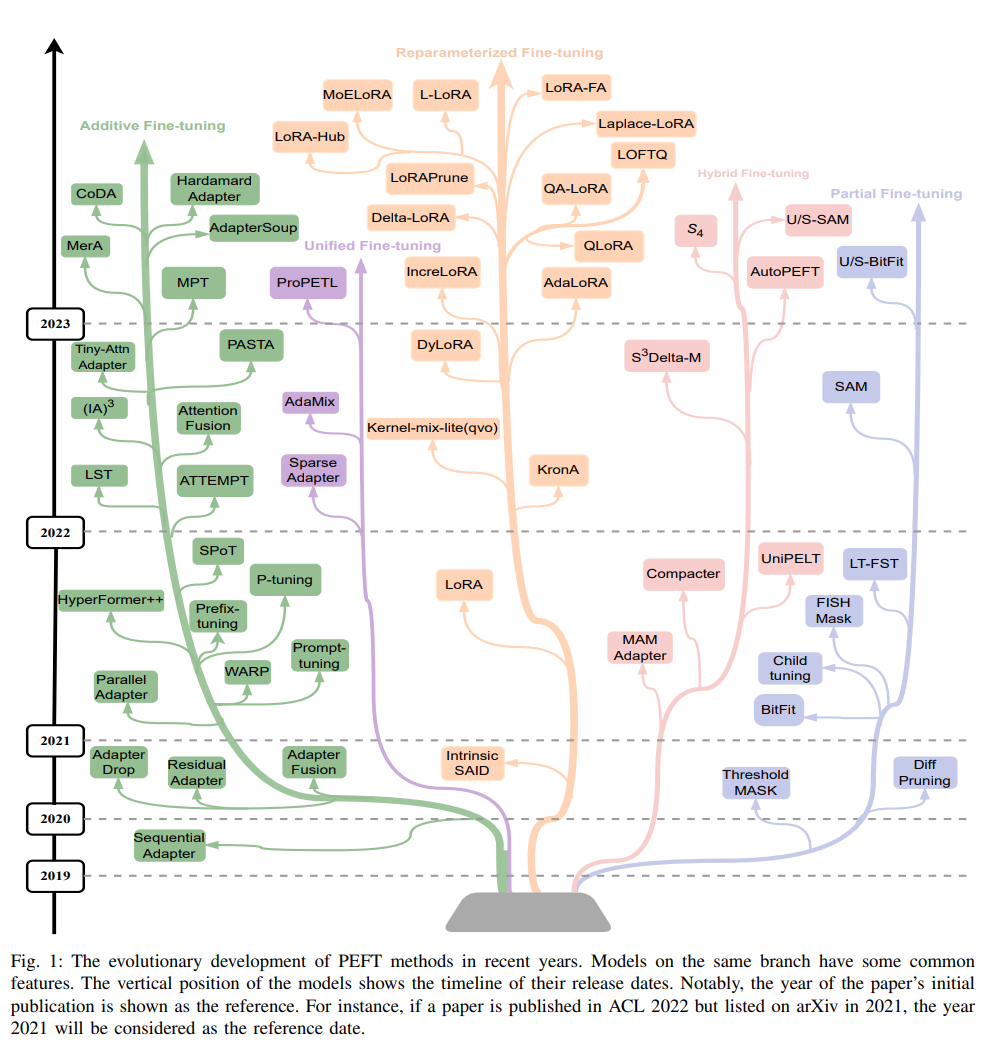

Of these, this tutorial will focus on Quantized Low-Rank Adaptation (QLoRA).

### **Instruction Tuning**
Instruction tuning is a fine-tuning method that aims to enhance an LLMs zero-shot performance by fine-tuning on many tasks. It was first introduced in the paper [*Finetuned Language Models are Zero-Shot Learners*](https://arxiv.org/pdf/2109.01652). In the words of the authors:

> "...instruction tuning—finetuning language models on a collection of datasets described via instructions—substantially improves zeroshot performance on unseen tasks"

The idea is that by training the model to complete different tasks with textual instructions, the model will learn to better deal with textual instructions in general. The dictionaries below are used to store information about the various tasks contained in the dataset that will be used. The response key  will be used to locate the portion of the text that should be used as labels.

In [ ]:
INSTRUCTION_PROMPTS = {
    'open_qa' : """### Instruction:\n\nAnswer the question below. Be as specific and concise as possible.\n### Question:\n{instruction}\n\n### Response:\n{response}""",
    'general_qa' : """### Instruction:\nAnswer the question below to the best of your konwledge.\n\n### Question:\n{instruction}\n\n### Response:\n{response}""",
    'classification' : """### Instruction:\nYou will be given a question and a list of potential answers to that question. You are to select the correct answers out of the available choices.\n\n### Question:\n{instruction}\n\n### Response:\n{response}""",
    'closed_qa' : """### Instruction:\nYou will be given a question to answer and context that contains pertinent information. Provide a concise and accurate response to the question using the information provided in the context.\n\n### Question:\n{instruction}\n\n### Context:\n{context}\n\n### Response:\n{response}""",
    'brainstorming' : """### Instruction:\nYou will be given a question that does not have a correct answer. You are to brainstorm one possible answer to the provided question.\n\n### Question:\n{instruction}\n\n### Response:\n{response}""",
    'information_extraction' : """### Instruction:\nYou will be given a question or query and some context that can be used to answer it. You are to extract relevant information from the provided context to provide an accurate response to the given query.\n\n### Question:\n{instruction}\n\n### Context:\n{context}\n\n### Response:\n{response}""",
    'summarization' : """### Instruction:\nYou will be given a question or request and context that can be used for your response. You are to summarize the provided context to provide an answer to the question.\n\n### Question:\n{instruction}\n\n### Context:\n{context}\n\n### Response:\n{response}""",
    'creative_writing' : """### Instruction:\nYou will be given a prompt that you are to write about. Be creative.\n\n### Prompt:\n{instruction}\n\n### Response:\n{response}"""
}

USE_CONTEXT = {
    'open_qa' : False,
    'general_qa' : False,
    'classification' : False,
    'closed_qa' : True,
    'brainstorming' : False,
    'information_extraction' : True,
    'summarization' : True,
    'creative_writing' : False
}

RESPONSE_KEY = """### Response:
"""

While the prompts differ slightly for every task, they maintain the same overall structure.

In [ ]:
for k, v in INSTRUCTION_PROMPTS.items():
  print(f"[{k}]\n{v}\n")

The data in the dataset will be formatted according to the prompts above. The resulting prompts will be tokenized and labelled for SFT in the following code.

In [ ]:
def get_databricks_dataset(
    tokenizer : LlamaTokenizer,
    max_length = 2048,
    input_prompts = INSTRUCTION_PROMPTS,
    use_context = USE_CONTEXT,
    valid_ratio=0.05,
):
    if not tokenizer.pad_token_id:
        tokenizer.pad_token_id = tokenizer.eos_token_id
        tokenizer.pad_token = tokenizer.eos_token

    dataset = load_dataset('databricks/databricks-dolly-15k', split='train', trust_remote_code=True)

    # Apply an instruction template to each of the data in the dataset, in accordance with the data's "category"\
    dataset = dataset.map(
        lambda data: {'instruction_prompt' : input_prompts[data['category']].format(instruction = data['instruction'], context = data['context'], response = data['response'])},
        batched = False
    )

    # Determine the starting index for the substring corresponding to the labels
    dataset = dataset.map(
        lambda data: {'label_str_idx' : len(RESPONSE_KEY) + data['instruction_prompt'].rfind(RESPONSE_KEY)},
        batched = False
    )

    # Tokenize the formatted instruction tuning data and return offset_mapping to be used to determine label ids
    dataset = dataset.map(
        lambda batch: tokenizer(batch['instruction_prompt'], return_offsets_mapping = True),
        batched = True
    )

    # Filter out data whose tokenized length exceeds the max length that has been set
    print(f"Dataset length before filtering: {str(len(dataset))}")
    dataset = dataset.filter(lambda data: len(data['input_ids']) <= max_length, batched = False)
    print(f"Dataset length after filtering: {str(len(dataset))}")

    # Use the starting index and offset mapping to determine which token ids correspond to the labels
    dataset = dataset.map(
        lambda data: {'label_tok_len' : len([offset_mapping for offset_mapping in data['offset_mapping'] if offset_mapping[0] >= data['label_str_idx']])},
        batched = False
    )
    dataset = dataset.map(
        lambda data: {'labels' : [-100] * (len(data['input_ids']) - data['label_tok_len']) + data['input_ids'][-data['label_tok_len']:]},
        batched = False
    )

    # Confirm that the label tokens correspond with the response
    print(f"Dataset length before filtering : {str(len(dataset))}")
    dataset = dataset.filter(
        lambda data: tokenizer.decode([label_tok for label_tok in data['labels'] if label_tok != -100]).strip() == data['response'].strip(),
        batched = False
    )
    print(f"Dataset length after filtering: {str(len(dataset))}")

    for i in range(3):
        print(f"===== EXAMPLE {str(i + 1)} =====")
        print(f"<Response>\n{dataset[i]['response']}\n")
        print(f"<Decoded Labels>\n" + tokenizer.decode([label_tok for label_tok in dataset[i]['labels'] if label_tok != -100]) + '\n')

    # Remove unneeded columns
    dataset = dataset.remove_columns(set(dataset.column_names) - {'input_ids', 'attention_mask', 'labels'})

    dataset = dataset.train_test_split(test_size = valid_ratio)
    return dataset['train'], dataset['test']

### **HuggingFace**
HuggingFace has developed several libraries that make fine-tuning easier to handle. Of these, we will be utilizing the PEFT, BitsAndBytes, and Transformers libraries to implement QLoRA.
<br>
<br>
First, we set up some fine-tuning configurations.

In [ ]:
def get_config():
    args = EasyDict()
    args.pretrained_model_name = 'TinyLlama/TinyLlama-1.1B-Chat-v1.0'   # The model from HuggingFace that we will be fine-tuning
    args.valid_ratio = 0.025                                            # Validation/Test size of dataset
    args.max_length = 2048                                              # Maximum length of input
    args.num_train_epochs = 0.1                                         # Number of epochs to train for, set to a small value for demonstration purposes
    args.batch_size_per_device = 1                                      # Batch size for training is set to 1 to reduce memory usage, modify if resources allow
    args.gradient_accumulation_steps = 4                                # Gradient accumulation configuration
    args.learning_rate = 1e-5                                           # Learning rate
    args.save_total_limit = 3                                           # How many times parameters will be saved during intermediate steps
    args.min_warmup_steps = 1000
    args.warmup_ratio = 0.1
    args.steps_between_save_eval_log = 50
    args.lora_r = 4                                                     # The rank configuration for LoRA
    args.lora_alpha = 4                                                 # The alpha configuration for LoRA
    args.lora_dropout = 0.05

    return args

### **Quantized Low-Rank Adaptation**
As the name suggests, QLoRA is a technique that combines quantization with low-rank adaptation. The two concepts are explained separately below.

### **Quantization**
According to [HuggingFace](https://huggingface.co/docs/optimum/en/concept_guides/quantization):
> Quantization is a technique to reduce the computational and memory costs of running inference by representing the weights and activations with low-precision data types like 8-bit integer (int8) instead of the usual 32-bit floating point (float32).

Because quantization is a process that decreases the precision of model parameters, it can inevitably lead to loss in accuracy. Quantization techniques focus on minimizing this loss by looking for the best way to project the parameters onto the specified space. In the [QLoRA paper](https://arxiv.org/pdf/2305.14314), the authors introduce two new quantization techniques: 4-bit NormalFloat (NF4) quantization and Double Quantizaiton.
<br>
<br>
In short, NF4 is a quantization technique that works by assigning each floating-point value to one of 16 available bins, each corresponding to one of the 16 values that can be represented with 4-bits. This is done in such a way that the number of floating-point values assigned to each of the bins is roughly equal.
<br>
<br>
Double Quantization is a two-step procedure that first quantizes parameters to 8-bits, which is then followed by further quantization to 4-bit representations. Double quantization was introduced as a method to reduce the memory footprints of the "quantization constants" that arise from the quantization process.
<br>
<br>
Some additional context for those interested:
<br>
<br>
Outliers can have a disproportionately large influence on how data is scaled for quantization. To mitigate the influences of these outliers, parameters are divided into smaller groups (of size 64 or 128, for example) called "blocks," after which quantization is performed separately on each individual block. Because each block is quantized on a different scale, the corresponding "scaling factors" (the "quantization constants" referrenced above) must also be stored, resulting in memory overhead. Double quantization is a proceduce that reduces this memory overhead.
<br>
<br>
For further details, please reference [symbl.ai](https://symbl.ai/developers/blog/a-guide-to-quantization-in-llms/)

### **Low-Rank Adaptation**
Low-Rank Adaptation is a PEFT technique that reduces the memory requirements of fine-tuning by modifying how the weight matrices of a model are updated during fine-tuning. The authors hypothesize that the model updates that occur during model adaptation may have a "low intrinsic rank." In other words, while the weight update matrices themselves may be large in size, the actual updates may be approximated by matrices of much smaller rank. This intuition suggests that the weight updates could potentially be approximated by a low-rank decomposition instead.
<br>
<br>
In other words:
<br>
<br>
$W+ΔW≈W+BA$
<br>
<br>
Where $ΔW∈ \mathbb{R} ^{d*k}$ represents a weight update matrix and $BA$ represents the low-rank decomposition of $ΔW$ such that $B∈ \mathbb{R} ^{d*r}$ and $B∈ \mathbb{R} ^{r*k}$. The authors select the rank $r$ such that $r≪min(d,k)$.
<br>
<br>
With this in mind, consider the number of parameters in $ΔW$ and $BA$. As defined above, $ΔW$ is comprised of $d*k$ parameters, while $B$ and $A$ are comprised of $d*r$ and $r*k$ parameters, respectively. The low-rank decomposition is comprised of a total of $r*(d + k)$ parameters, which means that the weight update matrix can be approximated with much fewer parameters when the rank $r$ is chosen to be much smaller than either $d$ or $k$.
<br>
<br>
As an example, let $ΔW∈ \mathbb{R} ^{1024*1024}$ and the rank $r$ be 8. In this case, the low-rank decomposition $BA$ would be such that $B∈ \mathbb{R} ^{1024*8}$ and $A∈ \mathbb{R} ^{8*1024}$. While $ΔW$ is comprised of $1048576$ parameters, $BA$ is comprised of $8*(1024 + 1024) = 16384$ in total. In other words, the low-rank decomposition approximates the weight update matrix with only $\frac{1}{64}$ of the parameters.
<br>
<br>
By approximating the weight update matrices in large language models with low-rank decomposition, LoRA enables fine-tuning with much fewer parameters than would be needed in traditionall full fine-tuning.

### **Fine-tuning Script**
The sample code below performs SFT using the Transformers Trainer. The overall process is actually quite simple:

1.   Load and pre-process the dataset using the function defined above
2.   Load the model and set up quantization and LoRA
3.   Pass the model and dataset to the Trainer
4.   Merge the LoRA weights with the model
5.   Push the model to HuggingFace

In [ ]:
def get_now():
    return datetime.now().strftime("%Y%m%d-%H%M%S")

def main(config):

    finetuned_model_name = f"{str(config.pretrained_model_name.split('/')[-1])}-{str(config.num_train_epochs)}E-QLoRA-Databricks-SFT-Test"

    # Initialize tokenizer, manually add pad token if model does not have one by default
    tokenizer = AutoTokenizer.from_pretrained(config.pretrained_model_name, padding_side = 'left')
    if not tokenizer.pad_token_id:
        tokenizer.pad_token_id = tokenizer.eos_token_id
        tokenizer.pad_token = tokenizer.eos_token

    # Retrieve databricks dataset as HuggingFace Dataset after pre-processing for labelling
    train_data, valid_data = get_databricks_dataset(
        tokenizer,
        max_length = config.max_length,
        valid_ratio=config.valid_ratio,
    )
    print("< Retrieved and formatted Databricks dataset >")

    # Get BitsAndBytesConfig for quantization
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
    )

    # Load model prepared for 8-bit quantization
    model = AutoModelForCausalLM.from_pretrained(
        config.pretrained_model_name,             # Pre-trained model name on HuggingFace
        quantization_config=quantization_config,  # Enable quantization with BitsAndBytesConfig defined above
        device_map = 'auto',
        trust_remote_code=True,                   # Some models require this option
    )

    # Enable gradient checkpointing, must pass keyword argument "use_reentrant" : False to avoid errors when using multiple GPUs
    model.gradient_checkpointing_enable(
        gradient_checkpointing_kwargs={'use_reentrant' : False},
    )

    # Prepare model for k-bit training
    model = prepare_model_for_kbit_training(model)

    # Configurations for Low-Rank Adaptation (https://huggingface.co/docs/peft/main/en/conceptual_guides/lora)
    l_config = LoraConfig(
        r=config.lora_r,                                       # Rank  : parameter that determines the rank of the decomposed matrices used in LoRA
        lora_alpha=config.lora_alpha,                          # Alpha : parameter that determines the scaling factor for LoRA
        target_modules=["q_proj","k_proj","v_proj","o_proj"],  # Set target modules for LoRA, check model achitectue for module names (print(AutoModelForCausalLM.from_pretrained()))
        lora_dropout=config.lora_dropout,                      # The dropout probability for LoRA layers
        bias="none",                                           # Specifies whether bias parameters should be trained
        task_type="CAUSAL_LM",                                 # The source code for LoraConfig does not seem to utilize this particular parameter (https://github.com/huggingface/peft/blob/main/src/peft/tuners/lora/config.py#L43)
        use_rslora = True                                      # When true, sets scaling factor to [alpha / sqrt(rank)] instead of default [alpha / rank]
    )

    # Get PEFT model with the LoRA configurations above
    model = get_peft_model(model, l_config)
    print("< Retrieved PEFT model >")

    # Customize training arguments
    training_args = transformers.TrainingArguments(
        output_dir = os.getcwd(),
        # bf16=True,                                                         ##### T4 does not support brain float (https://www.aewin.com/application/bfloat16-a-brief-intro/) #####
        # bf16_full_eval=True,                                               ##### T4 does not support brain float (https://www.aewin.com/application/bfloat16-a-brief-intro/) #####
        ddp_find_unused_parameters=False,                                    # Parameter passed to DistributedDataParallel, defaults to false if gradient checkpointing used
        eval_steps=config.steps_between_save_eval_log,                       # Number of update steps between two evaluations
        eval_accumulation_steps=1,                                           # Number of prediction steps to accumulate before moving to CPU, higher values lead to faster training but also require more memory
        evaluation_strategy="steps",                                         # Set to steps indicates that evaluation is performed and logged every eval_steps
        # fp16=True,                                                         ##### MUST ONLY USE ONE OF BF, FP #####
        # fp16_full_eval=True,                                               ##### MUST ONLY USE ONE OF BF, FP #####
        # gradient_accumulation_steps=config.gradient_accumulation_steps,    ##### Removed for memory #####
        gradient_checkpointing = True,                                       # Strategy that allows you to save memory during gradient updates, at the expense of time
        gradient_checkpointing_kwargs = {'use_reentrant' : False},           # Set to false to avoid errors when using multiple-gpus
        half_precision_backend="auto",                                       # Parameter for mixed-precision training
        learning_rate=config.learning_rate,                                  # Initial learning rate for optimizer
        lr_scheduler_type = 'cosine',                                        # SchedulerType
        logging_strategy="steps",                                            # Logging is done at every logging_steps
        logging_steps=config.steps_between_save_eval_log,                    # Number of update steps between two logs
        num_train_epochs=config.num_train_epochs,                            # Number of training epochs to perform
        optim="paged_adamw_8bit",                                            # Optimizer to use, valid names can be found at (https://github.com/huggingface/transformers/blob/v4.40.0/src/transformers/training_args.py#L141)
        per_device_train_batch_size=config.batch_size_per_device,            # Batch size per GPU for training
        per_device_eval_batch_size=config.batch_size_per_device * 2,         # Batch size per GPU for evaluation (usually set to higher value than for training due to smaller memory consumption)
        save_strategy="steps",                                               # Save is performed every save_steps steps
        save_steps=config.steps_between_save_eval_log,                       # Number of update steps between two checkpoint saves
        save_total_limit=5,                                                  # Limits the total number of saves, deletes older checkpoints
        # warmup_steps=warmup_steps,                                           # Steps used for a lienar warmup from 0 to learning_rate, overrides effects of warmup_ratio
    )
    print("< Loaded training arguments >")

    torch.cuda.empty_cache()

    trainer = transformers.Trainer(
        model=model,
        train_dataset= train_data,               # Dataset to use for evaluation, requires data of specific format (such as datasets.Dataset)
        eval_dataset= valid_data,                # Dataset to use for training, requires data of specific format (such as datasets.Dataset)
        args=training_args,                      # The training arguments set above
        data_collator= DataCollatorForSeq2Seq(   # The data collator to use, note that DataCollatorForLanguageModeling is not suitable for labelled data
            tokenizer,
        ),
    )
    model.config.use_cache = (
        False  # Silences warnings, re-enable for inference
    )

    # Perform pre-training evaluation
    # Details on data accepted by evaluate() can be found in HuggingFace documentation
    # https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.Trainer.evaluate
    pre_training_evaluation = trainer.evaluate(Dataset.from_dict(dict(valid_data[-5:])))

    # Perform training
    print("< Training in Progress >")
    trainer.train()
    trainer.save_model(os.path.join(LORA_ADAPTERS_DIR, finetuned_model_name + '-LoRA-Adapters'))

    # Perform post-training evaluation
    post_training_evaluation = trainer.evaluate(Dataset.from_dict(dict(valid_data[-5:])))

    # Free up as much memory as possible
    del trainer
    gc.collect()
    torch.cuda.empty_cache()

    # Pring pre-training and post-training evaluations
    print("< PRE-TRAINING EVAL >")
    print(pre_training_evaluation)
    print("< POST-TRAINING EVAL >")
    print(post_training_evaluation)

    # Free up as much memory as possible
    del model
    gc.collect()
    torch.cuda.empty_cache()

    model = AutoModelForCausalLM.from_pretrained(
        config.pretrained_model_name,
        quantization_config=quantization_config,
        device_map = 'cuda',
        trust_remote_code=True,  # Some models require this option
    )
    model = PeftModel.from_pretrained(model, os.path.join(LORA_ADAPTERS_DIR, finetuned_model_name + '-LoRA-Adapters'))                                                                            # PEFT 어댑터를 모델에 적용한다
    model = model.merge_and_unload()

    model.push_to_hub(f"Chahnwoo/{str(finetuned_model_name)}_{str(get_now())[:8]}")


In [ ]:
main(get_config())